(f_rs_io)=

---------------

```{admonition} Learning Objectives
- Open multiple common remotely sensed image types.
- Handle RGB, BGR, LandSat, PlanetScope images, and other sensor types.
- Mosaic multiple remotely sensed images.
- Create a time series stack.
- Write files to disk.
```

```{admonition} Review
* [Data Structures](c_features.md)
* [Raster Data ](c_rasters.md)
```

--------------

# Reading/Writing Remote Sensed Images

GeoWombat's file opening is meant to mimic Xarray and Rasterio. That is, rasters are typically opened with a context manager using the function `geowombat.open`. GeoWombat uses `xarray.open_rasterio` to load data into an `xarray.DataArray`. In GeoWombat, the data are always chunked, meaning the data are always loaded as Dask arrays. As with `xarray.open_rasterio`, the opened DataArrays always have at least 1 band.

## Opening a single image

Opening an image with default settings looks similar to `xarray.open_rasterio` and `rasterio.open`. `geowombat.open` expects a file name (`str` or `pathlib.Path`).

In [1]:
import geowombat as gw
from geowombat.data import l8_224078_20200518
import matplotlib.pyplot as plt

with gw.open(l8_224078_20200518) as src:
    print(src)

/home/mmann1123/miniconda3/envs/pygis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.DataArray (band: 3, y: 1860, x: 2041)> Size: 23MB
dask.array<open_rasterio-7b8d22ccb2fd7575dc4eae82f6f20c2a<this-array>, shape=(3, 1860, 2041), dtype=uint16, chunksize=(3, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 24B 1 2 3
  * x        (x) float64 16kB 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * y        (y) float64 15kB -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
Attributes: (12/13)
    transform:           (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                 32621
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan, nan, nan)
    _FillValue:          nan
    ...                  ...
    offsets:             (0.0, 0.0, 0.0)
    filename:            /home/mmann1123/miniconda3/envs/pygis/lib/python3.11...
    resampling:          nearest
    AREA_OR_POINT:       Area
    _data_are_separate:  0
    _data_are_stacked:   0


In the example above, `src` is an `xarray.DataArray`. Thus, printing the object will display the underlying Dask array dimensions and chunks, the DataArray named coordinates, and the DataArray attributes.

It automatically converts the coordinates stored in `x` and `y`, and the different bands are stored in `band`. To select a single band we can simply select it with `src.sel(band=1)`.  

Let's plot out what we have while removing missing values, stored at `0`, and switch the band order around to be RGB.

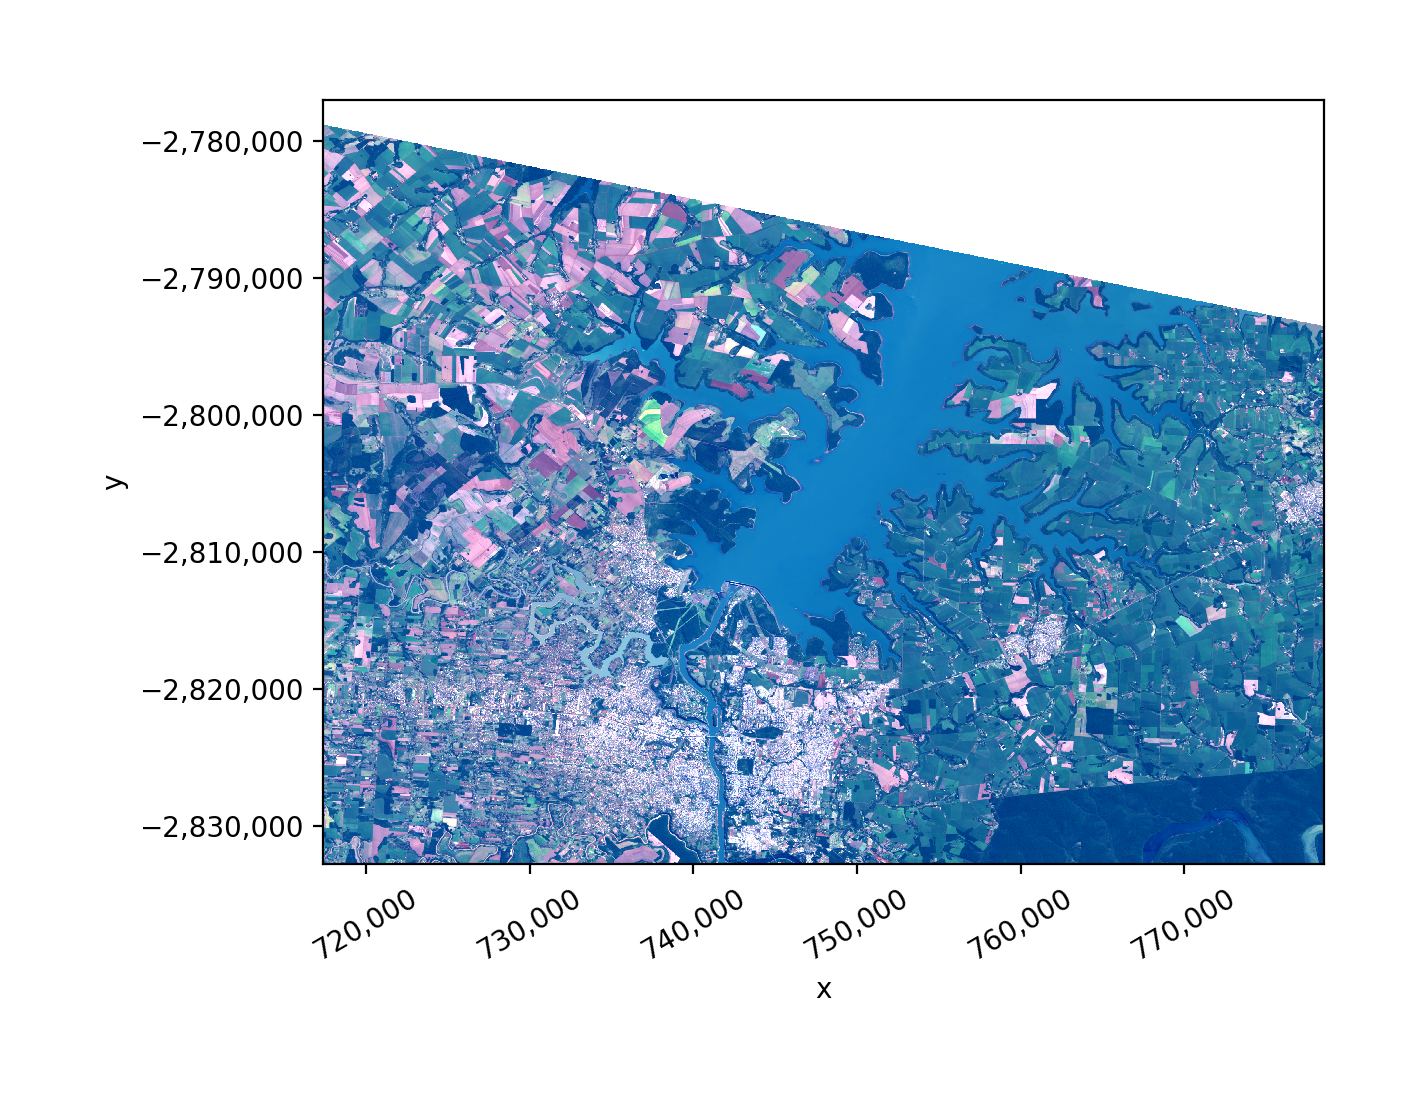

In [2]:
fig, ax = plt.subplots(dpi=200)
with gw.open(l8_224078_20200518) as src:
    src.where(src != 0).sel(band=[3, 2, 1]).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Opening multiple bands as a stack

Often, satellite bands will be stored in separate raster files. To open the files as one DataArray, specify a list instead of a file name.

In [3]:
from geowombat.data import l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4

with gw.open([l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4]) as src:
    print(src)

<xarray.DataArray (time: 3, band: 1, y: 1860, x: 2041)> Size: 23MB
dask.array<concatenate, shape=(3, 1, 1860, 2041), dtype=uint16, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 8B 1
  * x        (x) float64 16kB 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * y        (y) float64 15kB -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * time     (time) int64 24B 1 2 3
Attributes: (12/13)
    transform:           (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                 32621
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    _FillValue:          nan
    ...                  ...
    offsets:             (0.0,)
    filename:            ['LC08_L1TP_224078_20200518_20200518_01_RT_B2.TIF', ...
    resampling:          nearest
    AREA_OR_POINT:       Point
    _data_are_separate:  1
    _data_are_stacked:   1


By default, GeoWombat will stack multiple files by time. So, to stack multiple bands with the same timestamp, change the `stack_dim` keyword.

Also note the use of `band_names` parameter. Here we can set it to anything we want for instance `['blue','green','red']`.

In [4]:
from geowombat.data import l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4

with gw.open(
    [l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4],
    stack_dim="band",
    band_names=[1, 2, 3],
) as src:
    print(src)

<xarray.DataArray (band: 3, y: 1860, x: 2041)> Size: 23MB
dask.array<concatenate, shape=(3, 1860, 2041), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 16kB 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * y        (y) float64 15kB -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * band     (band) int64 24B 1 2 3
Attributes: (12/13)
    transform:           (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                 32621
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    _FillValue:          nan
    ...                  ...
    offsets:             (0.0,)
    filename:            ['LC08_L1TP_224078_20200518_20200518_01_RT_B2.TIF', ...
    resampling:          nearest
    AREA_OR_POINT:       Point
    _data_are_separate:  1
    _data_are_stacked:   1


You will see this looks the same as the multiband raster:

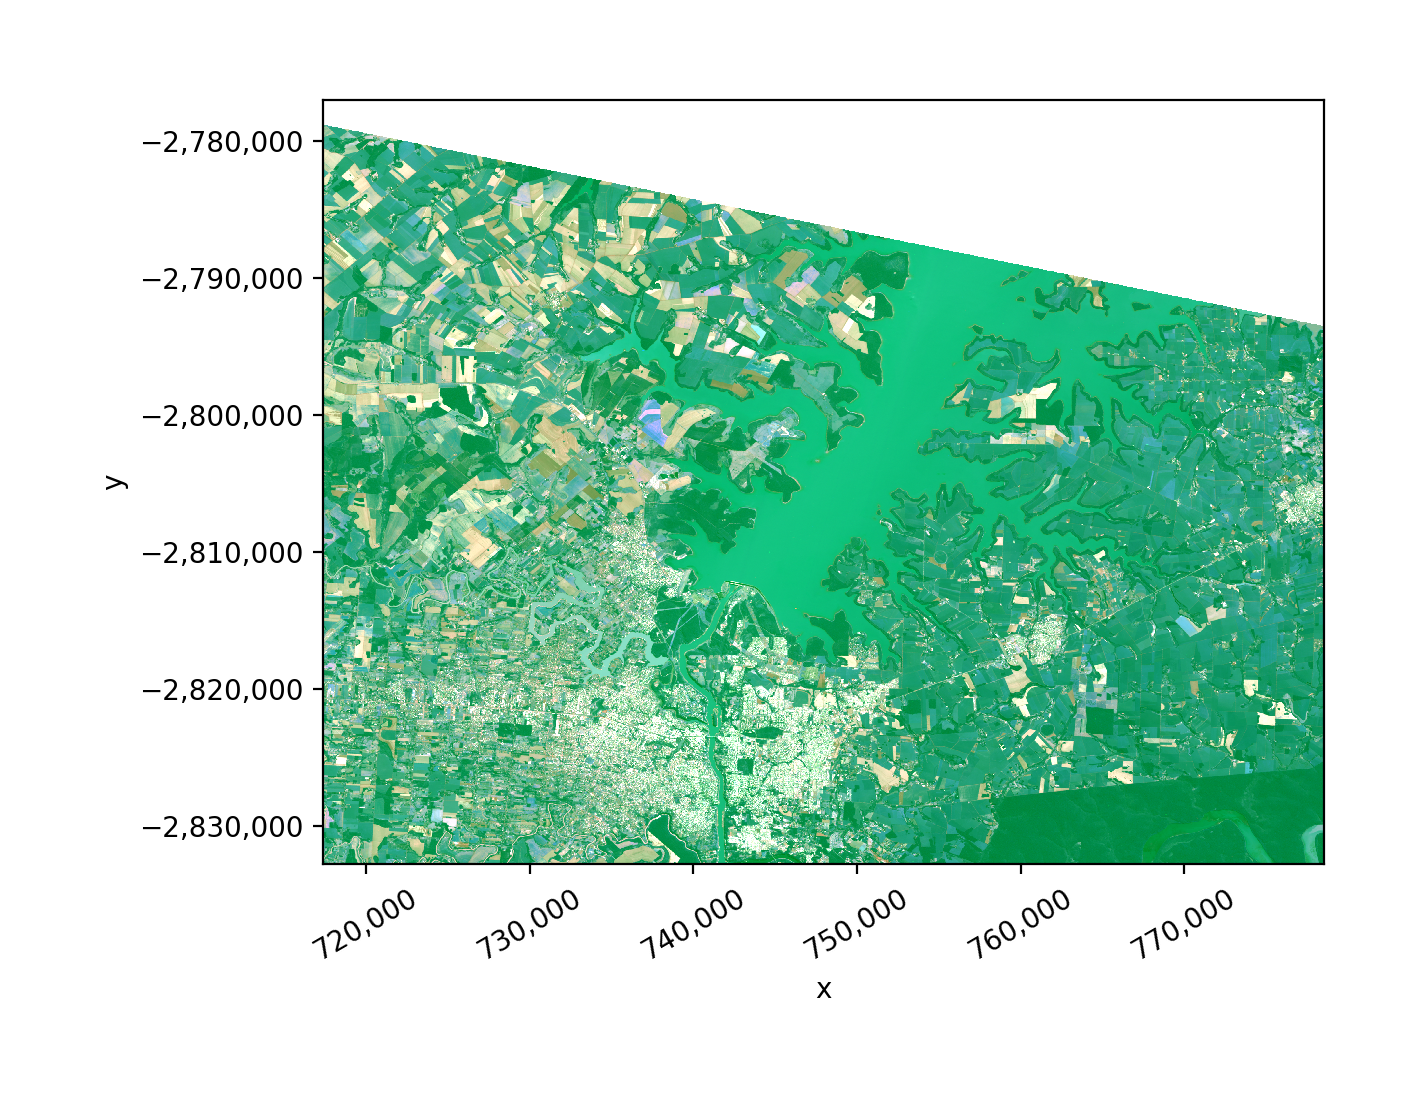

In [5]:
fig, ax = plt.subplots(dpi=200)
with gw.open(
    [l8_224078_20200518_B2, l8_224078_20200518_B3, l8_224078_20200518_B4],
    stack_dim="band",
    band_names=['blue','green','red'],
) as src:
    src.where(src != 0).sel(band=['red','blue','green']).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

```{note}
If time names are not specified with ``stack_dim`` = 'time', GeoWombat will attempt to parse dates from the file names. This could incur significant overhead when the file list is long. Therefore, it is good practice to specify the time names.
```

Overhead required to parse file names

```python
with gw.open(long_file_list, stack_dim='time') as src:
      ...
```

No file parsing overhead

```python
with gw.open(long_file_list, time_names=my_time_names, stack_dim='time') as src:
    ...
```

## Opening images from different sensors

One of many complications of using remotely sensed data is that there are so many different sensors such as LandSat, Sentinel, PlantScope etc each with their own band order and properties. Geowombat makes this much easier by providing a broad list of potential sensor configurations. [Read in more detail about sensor configurations here.](f_rs_crs_sensors) For this section, let's keep things simple and show you how to open a Sentinel 2 image using the configuration manager, frankly, it's pretty easy:

``` python
with gw.config.update(sensor='s2'):
    with gw.open('filepath.tif') as src:
        print(src.band)
```

To see all available sensor names, use the **avail_sensors** property.

``` python
with gw.open('filepath.tif') as src:
    for sensor_name in src.gw.avail_sensors:
        print(sensor_name)
```

## Opening multiple bands as a mosaic

When a list of files are given, GeoWombat will stack the data by default. To mosaic multiple files into the same band coordinate, use the **mosaic** keyword.

In [6]:
from geowombat.data import l8_224077_20200518_B2, l8_224078_20200518_B2

with gw.open([l8_224077_20200518_B2, l8_224078_20200518_B2],
              mosaic=True) as src:
    print(src)

<xarray.DataArray (band: 1, y: 1515, x: 2006)> Size: 24MB
dask.array<where, shape=(1, 1515, 2006), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 8B 1
  * x        (x) float64 16kB 6.94e+05 6.94e+05 ... 7.541e+05 7.542e+05
  * y        (y) float64 12kB -2.767e+06 -2.767e+06 ... -2.812e+06 -2.812e+06
Attributes: (12/13)
    transform:           (30.0, 0.0, 694005.0, 0.0, -30.0, -2766615.0)
    crs:                 32621
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    _FillValue:          nan
    ...                  ...
    offsets:             (0.0,)
    AREA_OR_POINT:       Point
    resampling:          nearest
    geometries:          [<POLYGON ((754185 -2812065, 754185 -2766615, 694005...
    _data_are_separate:  1
    _data_are_stacked:   0


Now let's take a look at the mosaiced band 2 image values.

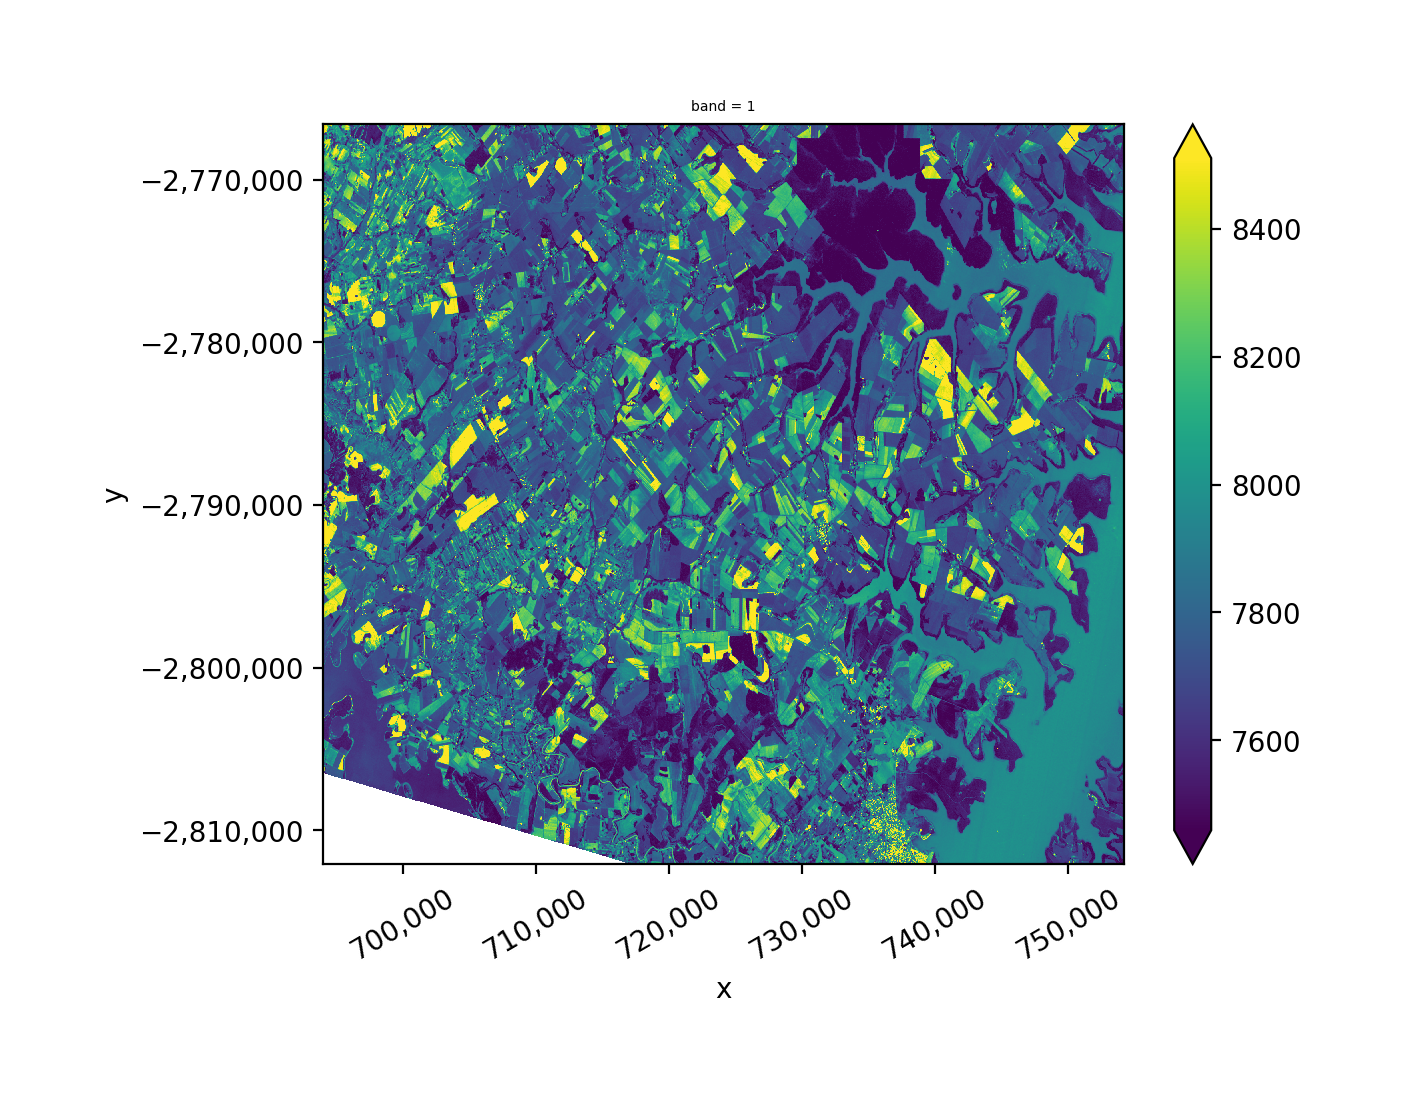

In [7]:
fig, ax = plt.subplots(dpi=200)
with gw.open([l8_224077_20200518_B2, l8_224078_20200518_B2],
              mosaic=True) as src:
    src.where(src != 0).sel(band=1).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

<!-- See :ref:`io` for more examples illustrating file opening. -->

## Create a Time Series Stack

Let's pretend for a moment that we have a time series of images from the same tile. We can stack them by passing a list of file names `[l8_224078_20200518, l8_224078_20200518]`, it also helps to be specific and assign `time_names=['t1', 't2']`, and specify which dimension we want to stack our data along with `stack_dim='time'`.

In [8]:
with gw.open([l8_224078_20200518, l8_224078_20200518],
            band_names=['blue', 'green', 'red'],
            time_names=['t1', 't2'],
            stack_dim='time') as src:
    print(src)

<xarray.DataArray (time: 2, band: 3, y: 1860, x: 2041)> Size: 46MB
dask.array<concatenate, shape=(2, 3, 1860, 2041), dtype=uint16, chunksize=(1, 3, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 16kB 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * y        (y) float64 15kB -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * time     (time) <U2 16B 't1' 't2'
  * band     (band) <U5 60B 'blue' 'green' 'red'
Attributes: (12/13)
    transform:           (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                 32621
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan, nan, nan)
    _FillValue:          nan
    ...                  ...
    offsets:             (0.0, 0.0, 0.0)
    filename:            ['LC08_L1TP_224078_20200518_20200518_01_RT.TIF', 'LC...
    resampling:          nearest
    AREA_OR_POINT:       Area
    _data_are_separate:  1
    _data_are_stacked:   1


## Setting Missing Values

(f_rs_io_setting_missing_values)=

Many raster files do not have the missing value set properly in their profile. Geowombat makes it easy to set or update the missing data value using `nodata` in either `gw.open` or even in `gw.config.update` if you prefer.

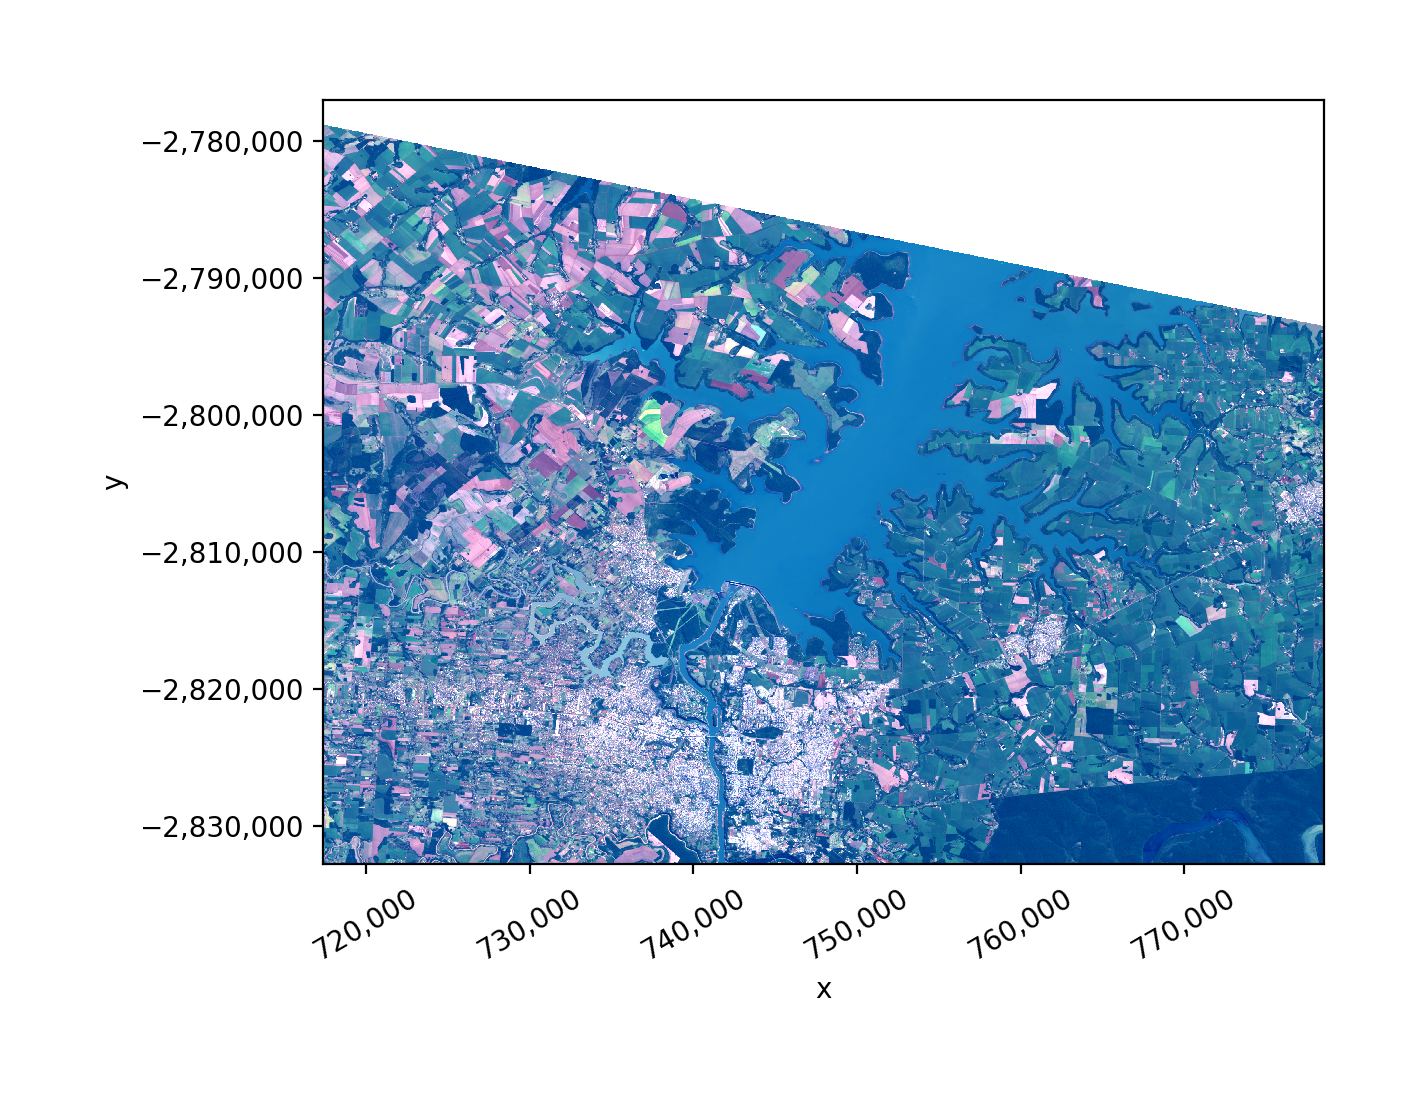

In [9]:
fig, ax = plt.subplots(dpi=200)
with gw.open(l8_224078_20200518, nodata=0) as src:
    # replace 0 with nan
    src = src.gw.mask_nodata()
    src.sel(band=[3, 2, 1]).gw.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Writing DataArrays to file

GeoWombat's I/O can be accessed through the `to_vrt` and `to_raster` functions. These functions use
Rasterio's `write` and Dask.array `store` functions as I/O backends. In the examples below,
``src`` is an ``xarray.DataArray`` with the necessary transform information to write to an image file.

Write to a VRT file.

``` python
from geowombat.data import l8_224077_20200518_B4

# Transform the data to lat/lon
with gw.config.update(ref_crs=4326):

    with gw.open(l8_224077_20200518_B4) as src:

        # Write the data to a VRT
        gw.to_vrt(src, 'lat_lon_file.vrt')
```

Write to a raster file.

``` python
import geowombat as gw

with gw.open(l8_224077_20200518_B4) as src:

    # Xarray drops attributes
    attrs = src.attrs.copy()

    # Apply operations on the DataArray
    src = src * 10.0

    src.attrs = attrs

    # Write the data to a GeoTiff
    src.gw.to_raster('output.tif',
                        verbose=1,
                        n_workers=4,    # number of process workers sent to ``concurrent.futures``
                        n_chunks=200)   # number of window chunks to send as concurrent futures
```

<!-- See :ref:`io-distributed` for more examples describing concurrent file writing with GeoWombat. -->